<a href="https://colab.research.google.com/github/resquilleur/TestWorkNeowoxCC/blob/master/Main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Часть 1. Загрузка и обработка данных. Подготовка наборов к обучению.

## Импорт библиотек

In [5]:
%cd TestWorkNeowoxCC

/content/TestWorkNeowoxCC


In [8]:
# !pip install pymorphy2

In [9]:
import pandas as pd
import numpy as np
import pymorphy2
import pickle

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

## Загрузка и обработка наборов данных

In [10]:
# загрузим набор данных
data_train = pd.read_csv('data/for_test_train.csv').drop(columns=['Unnamed: 0'])
# посмотрим кол-во экземпляров по классам
data_train.groupby('label').count()

,message
label,
tag_do_not_call,85
tag_no,122
tag_no_now,1
tag_not_now,67
tag_what_company,36
tag_who_is,50
tag_yes,191


In [11]:
# видим, что у нас есть всего один экземпляр класса tag_no_now, по смыслу подходит к тегу tag_not_now
# я решил объеденить эти классы
data_train[data_train['label'] == 'tag_no_now']

,message,label
543,"ты шутишь, у меня нет времени!",tag_no_now


In [12]:
# получим индекс нужного тега и переименуем его в правильный тег
idx = (data_train['label'] == 'tag_no_now')
data_train.loc[idx, 'label'] = 'tag_not_now'
data_train.groupby('label').count()

,message
label,
tag_do_not_call,85
tag_no,122
tag_not_now,68
tag_what_company,36
tag_who_is,50
tag_yes,191


In [13]:
# загрузим проверочный набор данных
data_valid = pd.read_csv('data/for_test_valid.csv', sep=';') # обязательно использовать такой разделитель, иначе не загрузится.
data_valid # проверочный набор

,Unnamed: 0,message
0,106,зачем это надо
1,162,ну
2,602,какая организация?
3,32,во имя чего?
4,642,вы тут?
5,419,да ну вас!
6,854,"приветствую, а что за организация?"
7,59,да хорошо
8,219,с какой радости?
9,112,и что дальше?


## Аугментация данных

In [14]:
# видим дисбаланс классов и в целом датасет небольшой, сделаем аугментацию для повышения качество распознования классов
aug_data_train = pd.DataFrame() # создадим пустой датафрейм
labels = data_train['label'].unique() # список уникальных меток классов

# сделаем так, чтобы обязательно попали все примеры, и добавим сгенерированные бутстрапом, так чтобы в сумме оказалось 200 шт каждого класса
for label in labels:
    n_samples = 0
    aug_data_train = pd.concat([aug_data_train, data_train[data_train['label'] == label]], ignore_index=True)
    if label not in ['tag_yes', 'tag_no']:
        n_samples = 200 - data_train[data_train['label'] == label].count()[0]
    aug_data_train = pd.concat([aug_data_train, data_train[data_train['label'] == label].sample(n=n_samples, replace=True, random_state=42)], ignore_index=True)

aug_data_train

,message,label
0,будьте здоровы!,tag_no
1,не имеется,tag_no
2,ни фига,tag_no
3,вы бредите,tag_no
4,"нет, нашел дурака",tag_no
...,...,...
1108,скажите по новой,tag_who_is
1109,"да, алло, я не расслышал",tag_who_is
1110,"да, алло, я не расслышал",tag_who_is
1111,это кто?,tag_who_is


## Формируем наборы

In [15]:
# неагментированные данные
x_train_not_aug = data_train['message'].values
y_train_not_aug = data_train['label'].values

# формируем x_valid
x_valid = data_valid['message'].values

# формируем x_train, y_train
x_train = aug_data_train['message'].values
y_train = aug_data_train['label'].values

# сделаем one_hot_encoding для набора классов
ohe_ytrain = OneHotEncoder()
y_train = ohe_ytrain.fit_transform(y_train.reshape(-1,1)).toarray() # аугментированный набор
y_train[0]

array([0., 1., 0., 0., 0., 0.])

In [16]:
# функция приведения к нормальной форме слова
def data_normalized(x_data):
    x_data_normal = []
    for frase in x_data:
        new_frase = ''
        words = frase.split()
        for word in words:
            word = word.replace('!', '').replace(',', '').replace('?', '')
            new_frase += f' {ma.normal_forms(word)[0]}'
        x_data_normal.append(new_frase)
    return np.array(x_data_normal)

In [17]:
# создаем анализатор слов
ma = pymorphy2.MorphAnalyzer()

# далее у нас будет два варианта набора данных с нормой и без
x_valid_norm = data_normalized(x_valid)
x_train_norm = data_normalized(x_train)

In [18]:
# токенизируем слова без нормирования
tokenizer = Tokenizer()
tokenizer.fit_on_texts(np.concatenate((x_train, x_valid), axis=0)) # обучим на всех словах, что у нас есть

tokenizer_norm = Tokenizer()
tokenizer_norm.fit_on_texts(np.concatenate((x_train_norm, x_valid_norm), axis=0)) # обучим на всех словах, что у нас есть

# запоним длину словарей + 1 (так как еще 0-ой индекс добавим)
vocabulary_len = len(tokenizer.word_index)+1
vocabulary_norm_len = len(tokenizer_norm.word_index)+1

In [19]:
# индексы в последовательность, дополним нулями перед последовательностью
x_train_seq = tokenizer.texts_to_sequences(x_train)
x_train_pad_seq = pad_sequences(x_train_seq, padding='pre')

x_train_seq_norm = tokenizer_norm.texts_to_sequences(x_train_norm)
x_train_pad_seq_norm = pad_sequences(x_train_seq_norm, padding='pre')

x_valid_seq = tokenizer.texts_to_sequences(x_valid)
x_valid_pad_seq = pad_sequences(x_valid_seq, padding='pre')

x_valid_seq_norm = tokenizer_norm.texts_to_sequences(x_valid_norm)
x_valid_pad_seq_norm = pad_sequences(x_valid_seq_norm, padding='pre')

In [20]:
# посмотрим что получилось
print(x_train_pad_seq[0])
print(x_train[0])

print(x_train_pad_seq_norm[0])
print(x_train_norm[0])

[  0   0   0   0   0   0   0 331 332]
будьте здоровы!
[  0   0   0   0   0   0   0 101 207]
 быть здоровый


In [21]:
# y_train общий сохраним для семплирования
y_train_full = y_train.copy()

# разобьем наборы на тестовый и тренировочный
# stratify позволяет сохранить баланс классов
x_train, x_test, y_train, y_test = train_test_split(x_train_pad_seq, y_train_full, test_size=0.2, stratify=y_train_full) 
x_train_norm, x_test_norm, y_train_norm, y_test_norm = train_test_split(x_train_pad_seq_norm, y_train_full, test_size=0.2, stratify=y_train_full)

# Часть 2. Обучение нейросетей

## Импорт библиотек

In [40]:
from TestWorkNeowoxCC.model_pack.model import *

import pandas as pd
import numpy as np

from tensorflow.keras.callbacks import ModelCheckpoint

## Создание сети

In [41]:
# используем фабрику для разных архитектур

fabric = ModelFabric()
model_lstm = fabric.create_model(name='lstm')
model_conv = fabric.create_model(name='conv')

## Обучение

Список параметров включает:

* params[0] - название сети
* params[1] - длина словаря (вход embedding)
* params[2] - num classes
* params[3] - emb size coef
* params[4] - dropout
* params[5] - layers filters size
* params[6] - Adam learning_rate
* params[7] - Adam decay
* params[8] - размер batch_size
* params[9] - кол-во эпох


In [42]:
# выберем два набора параметров (лучше всего показали себя на тестах) - тут можно реализовать генетику
models_params_list = [['lstm64', vocabulary_len, y_train.shape[1], 1, 7, 6, 1e-3, 1e-6, 16, 30],
                      ['lstm128', vocabulary_len, y_train.shape[1], 1, 7, 7, 1e-3, 1e-6, 32, 30]]

### Обучение на аугментированых данных без нормальной формы

In [43]:
# обучение
models = {} # тут будут лежать обученные модели
historys = {} # тут будут лежать истрии обучения

for params in models_params_list:
    
    # имя файла у каждой модели свое, сохраним лучшие веса
    model_checkpoint_callback = ModelCheckpoint(
        filepath=f'data/best_weights_{params[0]}.h5',
        save_weights_only=True,
        monitor='val_loss',
        mode='min',
        save_best_only=True)

    # генерим нужную архитектуру
    model = model_lstm.make_architecture(params[1:6])

    # компилируем модель
    model.compile(optimizer=Adam(learning_rate=params[6], decay=params[7]), loss='categorical_crossentropy', metrics=['accuracy'])

    # обучаем verbose=0
    history = model.fit(
        x_train,
        y_train,
        batch_size=params[8],
        epochs=params[9],
        validation_data=(x_test, y_test),
        callbacks=model_checkpoint_callback,
        verbose=0
        )
    
    models[params[0]] = model
    historys[params[0]] = history

### Обучение на аугментированых данных в нормальной форме

In [44]:
# обучение
models_norm = {} # тут будут лежать обученные модели
historys_norm = {} # тут будут лежать истрии обучения

for params in models_params_list:
    
    # имя файла у каждой модели свое, сохраним лучшие веса
    model_checkpoint_callback = ModelCheckpoint(
        filepath=f'data/best_weights_{params[0]}_norm.h5',
        save_weights_only=True,
        monitor='val_loss',
        mode='min',
        save_best_only=True)

    # генерим нужную архитектуру
    model = model_lstm.make_architecture(params[1:6])

    # компилируем модель
    model.compile(optimizer=Adam(learning_rate=params[6], decay=params[7]), loss='categorical_crossentropy', metrics=['accuracy'])

    # обучаем verbose=0
    history = model.fit(
        x_train_norm,
        y_train_norm,
        batch_size=params[8],
        epochs=params[9],
        validation_data=(x_test_norm, y_test_norm),
        callbacks=model_checkpoint_callback,
        verbose=0
        )
    
    models_norm[params[0]] = model
    historys_norm[params[0]] = history

## Вывод результатов

### Посмотрим графики обучения для анализа

In [ ]:
import matplotlib.pyplot as plt

Накопительный график loss по эпохам модели:lstm64


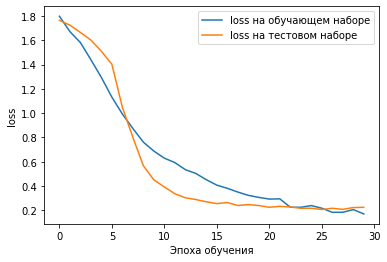

Накопительный график loss по эпохам модели:lstm128


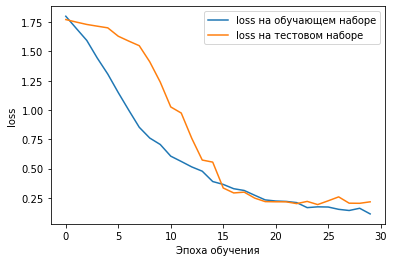

In [56]:
# посмотрим графики 128 сеть менее переобучилась
for key in historys.keys():
    print(f'Накопительный график loss по эпохам модели:{key}')
    plt.plot(historys[key].history['loss'], 
            label='loss на обучающем наборе')
    plt.plot(historys[key].history['val_loss'], 
            label='loss на тестовом наборе')
    plt.xlabel('Эпоха обучения')
    plt.ylabel('loss')
    plt.legend()
    plt.show()

Накопительный график loss по эпохам модели:lstm64


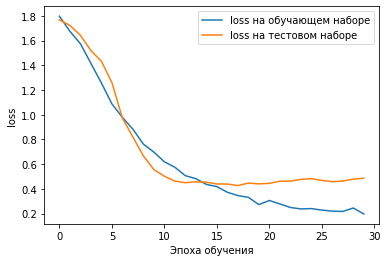

Накопительный график loss по эпохам модели:lstm128


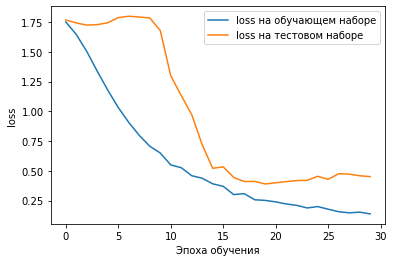

In [57]:
# посмотрим графики нормированных данных, как видим у 128 сети нет переобучения
for key in historys_norm.keys():
    print(f'Накопительный график loss по эпохам модели:{key}')
    plt.plot(historys_norm[key].history['loss'], 
            label='loss на обучающем наборе')
    plt.plot(historys_norm[key].history['val_loss'], 
            label='loss на тестовом наборе')
    plt.xlabel('Эпоха обучения')
    plt.ylabel('loss')
    plt.legend()
    plt.show()

### Вывод рузельтатов

In [46]:
# загрузим лучшие веса моделей
models['lstm128'].load_weights('data/best_weights_lstm128.h5')
models_norm['lstm128'].load_weights('data/best_weights_lstm128_norm.h5')

In [47]:
model2 = models['lstm128']
model2_norm = models_norm['lstm128']

In [48]:
# функция вывода результатов получает на вход модель x_test, y_test
def getResults(model, x_test, y_test):
    pred = model.predict(x_test) # получаем предсказание модели
    pred = np.argmax(pred, axis=1) # получаем метку класса с максимальным значением
    result = np.zeros((y_test.shape[1], 2)) # сделаем пустой numpy массив для записи результатов

    # проходимся по всей длине предсказаний
    for i in range(pred.shape[0]):
        # получаем индекс элемента, где у нас 1
        y_true_class_indx = list(y_test[i]).index(max(list(y_test[i])))
        if pred[i] == y_true_class_indx: # если предсказание верно, то увеличиваем счетчик в первом столбце, в строке номера индекса
            result[y_true_class_indx, 0] += 1
        else: # если не верно, то увеличиваем счетчик второго столбца
            result[y_true_class_indx, 1] += 1
    
    # готовим датафрейм с результатами
    result_test_df = pd.DataFrame(result, columns=['true', 'false'])
    result_test_df['percent_true'] = result_test_df['true'] / (result_test_df['true'] + result_test_df['false']) * 100 # считаем процент правильных предсказаний
    result_test_df['tag_name'] = [x[3:] for x in ohe_ytrain.get_feature_names()]
    result_mean = result_test_df['percent_true'].mean()
    print(f'Средний процент правильных предсказаний по всем классам составил: {result_mean}')
    print(result_test_df)

In [49]:
# результат на изначальном наборе (с 6 классами)
getResults(model2, x_test, y_test)

Средний процент правильных предсказаний по всем классам составил: 91.6798245614035
   true  false  percent_true          tag_name
0  38.0    2.0     95.000000   tag_do_not_call
1  19.0    6.0     76.000000            tag_no
2  40.0    0.0    100.000000       tag_not_now
3  40.0    0.0    100.000000  tag_what_company
4  39.0    1.0     97.500000        tag_who_is
5  31.0    7.0     81.578947           tag_yes


In [50]:
# результат на изначальном наборе (с 6 классами)
getResults(model2_norm, x_test_norm, y_test_norm)

Средний процент правильных предсказаний по всем классам составил: 82.97807017543859
   true  false  percent_true          tag_name
0  33.0    7.0     82.500000   tag_do_not_call
1   7.0   18.0     28.000000            tag_no
2  40.0    0.0    100.000000       tag_not_now
3  39.0    1.0     97.500000  tag_what_company
4  37.0    3.0     92.500000        tag_who_is
5  37.0    1.0     97.368421           tag_yes


## Формируем табличку с предсказанием классов для проверочного набора

In [51]:
valid_pred = model2.predict(x_valid_pad_seq)

valid_df = pd.DataFrame()
valid_df['massege'] = list(x_valid)
valid_df['softmax'] = list(valid_pred.round(2))
valid_df['class'] = list(np.argmax(valid_pred, axis=1))

valid_df['class'] = np.array([x[3:] for x in ohe_ytrain.get_feature_names()])[valid_df['class']]
valid_df

,massege,softmax,class
0,зачем это надо,"[0.0, 0.02, 0.0, 0.0, 0.39, 0.59]",tag_yes
1,ну,"[0.0, 0.01, 0.0, 0.0, 0.0, 0.99]",tag_yes
2,какая организация?,"[0.03, 0.46, 0.0, 0.03, 0.0, 0.47]",tag_yes
3,во имя чего?,"[0.0, 0.01, 0.0, 0.0, 0.0, 0.99]",tag_yes
4,вы тут?,"[0.02, 0.92, 0.0, 0.0, 0.03, 0.03]",tag_no
5,да ну вас!,"[0.03, 0.01, 0.0, 0.0, 0.01, 0.96]",tag_yes
6,"приветствую, а что за организация?","[0.0, 0.11, 0.0, 0.85, 0.01, 0.02]",tag_what_company
7,да хорошо,"[0.02, 0.06, 0.0, 0.0, 0.0, 0.92]",tag_yes
8,с какой радости?,"[0.0, 0.01, 0.0, 0.0, 0.0, 0.99]",tag_yes
9,и что дальше?,"[0.0, 0.01, 0.0, 0.0, 0.0, 0.99]",tag_yes


In [52]:
valid_pred = model2_norm.predict(x_valid_pad_seq_norm)

valid_df = pd.DataFrame()
valid_df['massege'] = list(x_valid)
valid_df['softmax'] = list(valid_pred.round(2))
valid_df['class'] = list(np.argmax(valid_pred, axis=1))

valid_df['class'] = np.array([x[3:] for x in ohe_ytrain.get_feature_names()])[valid_df['class']]
valid_df

,massege,softmax,class
0,зачем это надо,"[0.0, 0.02, 0.0, 0.0, 0.26, 0.71]",tag_yes
1,ну,"[0.01, 0.02, 0.0, 0.0, 0.0, 0.97]",tag_yes
2,какая организация?,"[0.0, 0.02, 0.0, 0.61, 0.0, 0.37]",tag_what_company
3,во имя чего?,"[0.0, 0.16, 0.03, 0.0, 0.0, 0.8]",tag_yes
4,вы тут?,"[0.0, 0.02, 0.0, 0.0, 0.0, 0.97]",tag_yes
5,да ну вас!,"[0.01, 0.07, 0.0, 0.0, 0.01, 0.91]",tag_yes
6,"приветствую, а что за организация?","[0.0, 0.0, 0.0, 1.0, 0.0, 0.0]",tag_what_company
7,да хорошо,"[0.0, 0.03, 0.0, 0.0, 0.0, 0.96]",tag_yes
8,с какой радости?,"[0.0, 0.02, 0.0, 0.0, 0.0, 0.98]",tag_yes
9,и что дальше?,"[0.0, 0.01, 0.0, 0.0, 0.0, 0.99]",tag_yes
